# Import

In [ ]:
!pip install transformers
# !pip install torch==1.2.0

In [ ]:
!ls /content/drive/MyDrive/1006_project/classification_code

Classification.ipynb  label_freqs	     preds	  scripts
data.py		      models.py		     __pycache__  utils.py
ensembling.ipynb      notebooks		     README.md
get_preds.py	      Playground_1006.ipynb  run.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# some_file.py
import sys
sys.path.append('/content/drive/MyDrive/1006_project/classification_code')
from data import *
from utils import *
from models import *

In [ ]:
import os
import re
import sys
import glob
import pickle
import random

import logging
import argparse
from tqdm import tqdm
from os.path import join

import math
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader

import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, LongformerTokenizer

# Classification

In [ ]:
class arguments:
  def __init__(self):
    # Model name or directory from transformers library or local dir. Tokenizer uses the same name or dir.
    self.model_name=""
    self.attention="store_true"
    self.n_epochs=30
    self.batch_size=32
    self.maxpool_size=32
    self.max_len=512
    self.n_gpu=1
    self.lr=0.01
    self.eps=1e-8
    self.device="cuda:0"
    self.seed=28
    self.data_dir="drive/MyDrive/1006_project/mimic3_preprocessed_data"
    self.load_data_cache="store_true"
    self.checkpt_path="drive/MyDrive/1006_project/checkpt_classification"
    self.train_from_checkpt="store_true"
    self.save_best_f1="store_true"
    self.save_best_acc="store_true"
    self.freeze=1
    self.tokenizer=""

In [ ]:
class ClassficationProbing(nn.Module):
  def __init__(self,n_class=50):
    super().__init__()
    self.c = n_class
    self.hid = 768

    # pooler
    # self.dense=nn.Linear(self.hid,self.hid)
    # self.activation=nn.Tanh()

    # fully connect layer
    # self.layers = nn.Sequential(
    #         nn.Linear(self.hid, self.hid),
    #         nn.ReLU(),
    #         nn.Linear(self.hid, self.c)
    #     )
    self.layers=nn.Linear(self.hid,self.c)

  def forward(self,x):
    # t1=self.dense(x)
    # t2=self.activation(t1)
    logits=self.layers(x)
    return logits

In [ ]:
def load_data(args):
  train_dataset, val_dataset, test_dataset = load_tensor_cache(args)
  train_loader = DataLoader(dataset=train_dataset,
                          batch_size=args.batch_size,
                          shuffle=False)
  val_loader = DataLoader(dataset=val_dataset,
                          batch_size=args.batch_size,
                          shuffle=False)
  test_loader = DataLoader(dataset=test_dataset,
                            batch_size=args.batch_size,
                            shuffle=True)
  with open('/content/drive/MyDrive/1006_project/clinical_nlp_cap_20/probing/local_bs32_seed28_'+args.model_name+'_probing_train.pkl', 'rb') as ifp:
    train_layers_file = pickle.load(ifp)
  with open(r'/content/drive/MyDrive/1006_project/clinical_nlp_cap_20/probing/local_bs32_seed28_'+args.model_name+'_probing_val.pkl', "rb") as input_file:
    val_layers_file = pickle.load(input_file)

  train_layers=train_layers_file['all_layers']
  val_layers=val_layers_file['all_layers']
  return train_layers,val_layers,train_loader,val_loader

In [ ]:
def eval(args, model, val_loader,val_layer):
    model.eval()
    total_loss = 0.
    num_examples = 0
    criterion = torch.nn.BCEWithLogitsLoss()
    k = 5
    y = []
    yhat = []
    yhat_raw = []
    all_layers=[]
    all_logits=[]

    with torch.no_grad():
        for layer_re,(idx, (input_ids, attn_masks, labels)) in zip(val_layer,enumerate(val_loader)):
        # no get_val_snippets, directly get 512 from bert
            all_preds = []
            layers=[]
            some_logits=[]
            #input_ids, attn_mask, list_labels = get_val_snippets(args, input_ids, attn_mask, labels)
            for i in range(len(input_ids)):   
        
                input_id=input_ids[i]
                attn_mask=attn_masks[i]
                length=len(input_id)
                layer=layer_re[i]

                input_id=input_id[0:args.max_len]
                attn_mask=attn_mask[0:args.max_len]

                # add batch size as 1
                input_id=input_id.unsqueeze(0)
                attn_mask=attn_mask.unsqueeze(0)
                # target shape: [1,50]
                target=labels[i].unsqueeze(0)

                # if args.probing:
                #     each_res,logits=model(input_id.to(args.device), attn_mask.to(args.device),length)
                #     if len(layers)>0:
                #         layers=[torch.cat([layers[i],each_res[i]],dim=0) for i in range(len(each_res))]
                #         some_logits=torch.cat([some_logits,logits],dim=0)
                #     else:
                #         layers=each_res
                #         some_logits=logits
                # else:
                #     # logits shape: [1,50]
                # layer=othermodel.pooler(layer.unsqueeze(1))
                logits = model(layer).unsqueeze(0)

                loss = criterion(logits.to(args.device), target.to(args.device))
                logits = torch.sigmoid(logits)
            
                batch_loss = 0.
                num_snippets = 0

                num_snippets += input_id.size(0)
                batch_loss += loss.item() * input_id.size(0)
                all_preds.append(logits)



            #Report results
            total_loss += batch_loss
            # logits: [batch_size,50)]
            logits = torch.cat(all_preds, dim=0)
            num_examples += num_snippets

        
            y.append(labels.cpu().detach().numpy())
            yhat.append(np.round(logits.cpu().detach().numpy()))
            yhat_raw.append(logits.cpu().detach().numpy())
        

        # Compute scores with results
        y = np.concatenate(y, axis=0)
        yhat = np.concatenate(yhat, axis=0)
        yhat_raw = np.concatenate(yhat_raw, axis=0)
        metrics = all_metrics(yhat, y, k=k, yhat_raw=yhat_raw)

        print('validation loss is {}.'.format(total_loss/num_examples))
        # print("[MACRO] acc, prec, rec, f1, auc")
        # print("{}, {}, {}, {}, {}".format(metrics["acc_macro"],
        #                                   metrics["prec_macro"],
        #                                   metrics["rec_macro"],
        #                                   metrics["f1_macro"],
        #                                   metrics["auc_macro"]))
        # print("[MICRO] accuracy, precision, recall, f-measure, AUC")
        # print("{}, {}, {}, {}, {}".format(metrics["acc_micro"],
        #                                   metrics["prec_micro"],
        #                                   metrics["rec_micro"],
        #                                   metrics["f1_micro"],
        #                                   metrics["auc_micro"]))

        # for metric, val in metrics.items():
        #     if metric.find("rec_at") != -1:
        #         print("{}: {}".format(metric, val))
        
        metrics["val_loss"]=total_loss/num_examples

        return metrics

In [ ]:
def train(args, train_loader, val_loader,train_layer,val_layer):
    # Define model, parallel training, optimizer.
    model = ClassficationProbing(50)
    model = model.to(args.device)
    

    if args.n_gpu > 1:
        device_ids = [_ for _ in range(args.n_gpu)]
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad],lr=float(args.lr),eps=float(args.eps))

    history_metrics = []
    start_epoch = 0
    best_f1 = 0.
    best_auc = 0.
    best_val=0
    overall_res=[]

    criterion = torch.nn.BCEWithLogitsLoss()
    model.zero_grad()

    #Train
    for i in range(start_epoch, args.n_epochs):
        total_loss = 0.
        num_examples = 0
        all_layers=[]
        all_logits=[]
        for layer_tp,(idx, (input_ids, attn_masks, labels)) in zip(train_layer,enumerate(train_loader)):

            model.train()
            layers=[]
            some_logits=[]
            for j in range(len(input_ids)):

                input_id=input_ids[j]
                attn_mask=attn_masks[j]
                length=len(input_id)
                layer=layer_tp[j]

                input_id=input_id[0:args.max_len]
                attn_mask=attn_mask[0:args.max_len]

                # add batch size as 1
                input_id=input_id.unsqueeze(0)
                attn_mask=attn_mask.unsqueeze(0)

                # if args.probing:
                #     each_res,logits=model(input_id.to(args.device), attn_mask.to(args.device),length)
                #     if len(layers)>0:
                #         layers=[torch.cat([layers[i],each_res[i]],dim=0) for i in range(len(each_res))]
                #         some_logits=torch.cat([some_logits,logits],dim=0)
                #     else:
                #         layers=each_res
                #         some_logits=logits
                # else:
                #     # logits shape: [1,50]
                #print(torch.cat([layer.unsqueeze(1)]*length,dim=1).shape)
                # layer=othermodel.pooler(layer.unsqueeze(1))
                logits = model(layer).unsqueeze(0)

                target=labels[j].unsqueeze(0)
                # print(logits.shape,target.shape)
                loss = criterion(logits.to(args.device), target.to(args.device))
                logits = torch.mean(torch.sigmoid(logits), dim=0)


                batch_loss = 0.
                num_snippets = 0

                loss.backward()
                optimizer.step()
                model.zero_grad()

                #Aggregatings losses
                num_snippets += input_id.size(0)
                batch_loss += loss.item() * input_id.size(0)

            num_examples += num_snippets
            total_loss += batch_loss
        
        print('')
        print('epoch: {}'.format(i+1))
        print('train loss is {}.'.format(total_loss / num_examples))
        sys.stdout.flush()
        metrics = eval(args, model, val_loader,val_layer)

        if args.save_best_f1:
            if metrics["f1_micro"] > best_f1:
                best_f1 = metrics["f1_micro"]
                torch.save(model, args.checkpt_path+'_best_f1.pt')
        if args.save_best_f1:
            if metrics["auc_micro"] > best_auc:
                best_auc = metrics["auc_micro"]
                torch.save(model, args.checkpt_path+'_best_auc.pt')

        history_metrics.append({'epoch':i, 'metrics':metrics})
        torch.save(model, args.checkpt_path+'_last.pt')
        pickle.dump({'best_f1': best_f1,
                    'best_auc': best_auc,
                    'hist':history_metrics}, open(args.checkpt_path+'_hist.pkl','wb'))
        
        if best_val>metrics["val_loss"]:
          break
        else:
          best_val=metrics["val_loss"]
    
    return metrics


In [ ]:
# load results
def process(args,train_layers,val_layers,train_loader,val_loader):
  n=len(train_layers)
  total_res=[]

  for layer_id in range(n):
    model=ClassficationProbing(50).to(args.device)
    optimizer = optim.Adam(model.parameters(),lr=float(args.lr),eps=float(args.eps))
    criterion = torch.nn.BCEWithLogitsLoss()
    print("\n")
    print("=======================================================")
    print("layer id: ",layer_id)
    train_layer=train_layers[layer_id]
    val_layer=val_layers[layer_id]

    res=train(args, train_loader, val_loader,train_layer,val_layer)
    print("[MACRO] acc, prec, rec, f1, auc")
    print("{}, {}, {}, {}, {}".format(res["acc_macro"],
                                      res["prec_macro"],
                                      res["rec_macro"],
                                      res["f1_macro"],
                                      res["auc_macro"]))
    total_res.append(res)
    print(len(total_res))
  return total_res


In [ ]:
args=arguments()
args.model_name="bert_mimic"
args.tokenizer="mimic_tokenizer"
print("Data Processing...")
train_layers,val_layers,train_loader,val_loader=load_data(args)
print("Classification...")
res1=process(args,train_layers,val_layers,train_loader,val_loader)

Data Processing...
Classification...


layer id:  0

epoch: 1
train loss is 0.32470695886451734.
validation loss is 0.3369334742426872.
rec_at_5: 0.24758568607000642
prec_at_5: 0.28607755880483154

epoch: 2
train loss is 0.308588718148795.
validation loss is 0.32814352691173554.
rec_at_5: 0.27352948780052144
prec_at_5: 0.3159567705022251
[MACRO] acc, prec, rec, f1, auc
0.043783810140768736, 0.21437176043464917, 0.05846218661423523, 0.09187010633326416, 0.7180447106517898
1


layer id:  1

epoch: 1
train loss is 0.30814251620248845.
validation loss is 0.3435341060161591.
rec_at_5: 0.2896893592210413
prec_at_5: 0.3273998728544183

epoch: 2
train loss is 0.2909872358436641.
validation loss is 0.3402680599689484.
rec_at_5: 0.3133610835074584
prec_at_5: 0.3521932612841704
[MACRO] acc, prec, rec, f1, auc
0.11893779115072327, 0.3263877511189646, 0.17851570256305205, 0.23079794077095572, 0.7497906754939246
2


layer id:  2

epoch: 1
train loss is 0.30693901374406024.
validation loss is 0.34391

In [ ]:
args=arguments()
args.model_name="longformer_mimic"
args.tokenizer="mimic_tokenizer"
print("Data Processing...")
train_layers,val_layers,train_loader,val_loader=load_data(args)
print("Classification...")
res_longformer_mimic=process(args,train_layers,val_layers,train_loader,val_loader)

Data Processing...
Classification...


layer id:  0

epoch: 1
train loss is 0.3129704990994789.
validation loss is 0.31695138439536097.
rec_at_5: 0.30760366425755076
prec_at_5: 0.34507310870947233

epoch: 2
train loss is 0.29558003599582455.
validation loss is 0.3002534982562065.
rec_at_5: 0.3657183275207736
prec_at_5: 0.4045772409408774
[MACRO] acc, prec, rec, f1, auc
0.0636187866799622, 0.4000285707530245, 0.07010071213800476, 0.11929606899996113, 0.7682598170185604
1


layer id:  1

epoch: 1
train loss is 0.42630536820400844.
validation loss is 0.6547301006317139.
rec_at_5: 0.2140488922956561
prec_at_5: 0.24081373172282267

epoch: 2
train loss is 0.41687769341197883.
validation loss is 0.6384385615587235.
rec_at_5: 0.20854340528554577
prec_at_5: 0.2375079465988557
[MACRO] acc, prec, rec, f1, auc
0.10212606729198079, 0.29755190956230615, 0.2394938314929631, 0.26538464581842963, 0.7166387589756931
2


layer id:  2

epoch: 1
train loss is 0.4177225477139469.
validation loss is 0.810851

In [ ]:
res_longformer_mimic

[{'acc_macro': 0.0636187866799622,
  'acc_micro': 0.10254835738409579,
  'auc_macro': 0.7682598170185604,
  'auc_micro': 0.7945706841777652,
  'f1_at_5': 0.38416763114802455,
  'f1_macro': 0.11929606899996113,
  'f1_micro': 0.18602060707323864,
  'prec_at_5': 0.4045772409408774,
  'prec_macro': 0.4000285707530245,
  'prec_micro': 0.6724832214765101,
  'rec_at_5': 0.3657183275207736,
  'rec_macro': 0.07010071213800476,
  'rec_micro': 0.10793924377895077,
  'val_loss': 0.3002534982562065},
 {'acc_macro': 0.10212606729198079,
  'acc_micro': 0.1331664980565465,
  'auc_macro': 0.7166387589756931,
  'auc_micro': 0.6753253227352801,
  'f1_at_5': 0.22208526330815512,
  'f1_macro': 0.26538464581842963,
  'f1_micro': 0.23503430128747296,
  'prec_at_5': 0.2375079465988557,
  'prec_macro': 0.29755190956230615,
  'prec_micro': 0.20843403616968081,
  'rec_at_5': 0.20854340528554577,
  'rec_macro': 0.2394938314929631,
  'rec_micro': 0.2694172142626306,
  'val_loss': 0.6384385615587235},
 {'acc_macro'

In [ ]:
args=arguments()
args.model_name="longformer"
args.tokenizer="Longformer_base"
print("Data Processing...")
train_layers,val_layers,train_loader,val_loader=load_data(args)
print("Classification...")
res_longformer=process(args,train_layers,val_layers,train_loader,val_loader)

Data Processing...
Classification...


layer id:  0

epoch: 1
train loss is 0.32808878599655017.
validation loss is 0.40518263444304464.

epoch: 2
train loss is 0.3126126454163917.
validation loss is 0.3584545511007309.
[MACRO] acc, prec, rec, f1, auc
0.014284023612628156, 0.1742794730284298, 0.018450361820494563, 0.0333681532781908, 0.721015119874862
1


layer id:  1

epoch: 1
train loss is 0.447908713000094.
validation loss is 0.7698238098621368.

epoch: 2
train loss is 0.5453544556358351.
validation loss is 0.6530972078442574.
[MACRO] acc, prec, rec, f1, auc
0.048096146817266094, 0.24565578158747392, 0.06077035124812186, 0.0974367818766437, 0.6769487276374178
2


layer id:  2

epoch: 1
train loss is 0.4919142713659837.
validation loss is 0.8195000321790576.

epoch: 2
train loss is 0.619166640115703.
validation loss is 0.6986191178113222.
[MACRO] acc, prec, rec, f1, auc
0.0393653228548841, 0.1667493639718981, 0.05299956769547715, 0.08043401291600857, 0.6718336201542299
3


layer id: 

In [ ]:
res_longformer

[{'acc_macro': 0.014284023612628156,
  'acc_micro': 0.03022722534917657,
  'auc_macro': 0.721015119874862,
  'auc_micro': 0.7332226709848388,
  'f1_at_5': 0.3138462006921055,
  'f1_macro': 0.0333681532781908,
  'f1_micro': 0.05868069607446377,
  'prec_at_5': 0.32917991099809285,
  'prec_macro': 0.1742794730284298,
  'prec_micro': 0.4825291181364393,
  'rec_at_5': 0.2998774446707002,
  'rec_macro': 0.018450361820494563,
  'rec_micro': 0.031239900894107508,
  'val_loss': 0.3584545511007309},
 {'acc_macro': 0.048096146817266094,
  'acc_micro': 0.070442695020959,
  'auc_macro': 0.6769487276374178,
  'auc_micro': 0.6885899101678084,
  'f1_at_5': 0.271411769023931,
  'f1_macro': 0.0974367818766437,
  'f1_micro': 0.13161413562559696,
  'prec_at_5': 0.29065479974570885,
  'prec_macro': 0.24565578158747392,
  'prec_micro': 0.5804549283909014,
  'rec_at_5': 0.254558520965689,
  'rec_macro': 0.06077035124812186,
  'rec_micro': 0.07422169557255198,
  'val_loss': 0.6530972078442574},
 {'acc_macro':

# Images

In [ ]:
import seaborn as sns
import matplotlib.style as style 
import pandas as pd
import matplotlib.pyplot as plt
style.available
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
sns.set_style("darkgrid")


In [ ]:
#pickle.dump({"res_bert":res_bert,"res_longformer":res_longformer,"res_longformer_mimic":res_longformer_mimic}, open('/content/drive/MyDrive/1006_project/clinical_nlp_cap_20/probing/res_summary.pkl','wb'))
with open('/content/drive/MyDrive/1006_project/clinical_nlp_cap_20/probing/res_summary.pkl', 'rb') as ifp:
    res_summary = pickle.load(ifp)

In [ ]:
res_bert=res_summary["res_bert"]
res_longformer=res_summary["res_longformer"]
res_longformer_mimic=res_summary["res_longformer_mimic"]

In [ ]:
def plotting(data,title):
  style.available
  sns.set_style("darkgrid")

  acc_macro,acc_micro=[],[]
  auc_macro,auc_micro=[],[]
  f1_at_5,f1_macro,f1_micro=[],[],[]
  prec_at_5,prec_macro,prec_micro=[],[],[]
  rec_at_5,rec_macro,rec_micro=[],[],[]
  val_loss=[]
  for res in data:
    acc_macro.append(res["acc_macro"])
    acc_micro.append(res["acc_micro"])
    auc_macro.append(res["auc_macro"])
    auc_micro.append(res["auc_micro"])
    f1_at_5.append(res["f1_at_5"])
    f1_macro.append(res["f1_macro"])
    f1_micro.append(res["f1_micro"])
    rec_at_5.append(res["rec_at_5"])
    rec_macro.append(res["rec_macro"])
    rec_micro.append(res["rec_micro"])
    val_loss.append(res["val_loss"])
  acc_macro=[(k-min(acc_macro))/max(acc_macro) for k in acc_macro]
  auc_macro=[(k-min(auc_macro))/max(auc_macro) for k in auc_macro]
  f1_macro=[(k-min(f1_macro))/max(f1_macro) for k in f1_macro]
  df1=pd.DataFrame()
  df1["layers"]=["0","1","2","3","4","5","6","7","8","9","10","11","12"]*3
  df1["results"]=pd.concat([pd.Series(acc_macro),pd.Series(auc_macro),pd.Series(f1_macro)],axis=0,ignore_index=True)
  df1["metric type"]=pd.concat([pd.Series(["acc_macro"]*13),pd.Series(["auc_macro"]*13),pd.Series(["f1_macro"]*13)],axis=0,ignore_index=True)
  sns.lineplot(x="layers",y="results",style="metric type",data=df1, hue="metric type",markers=True,dashes=False,palette="rocket").set_title(title)
  df2=pd.DataFrame()
  df2["acc_macro"]=acc_macro
  df2["auc_macro"]=auc_macro
  df2["f1_macro"]=f1_macro
  df2["f1_micro"]=f1_micro
  return df2

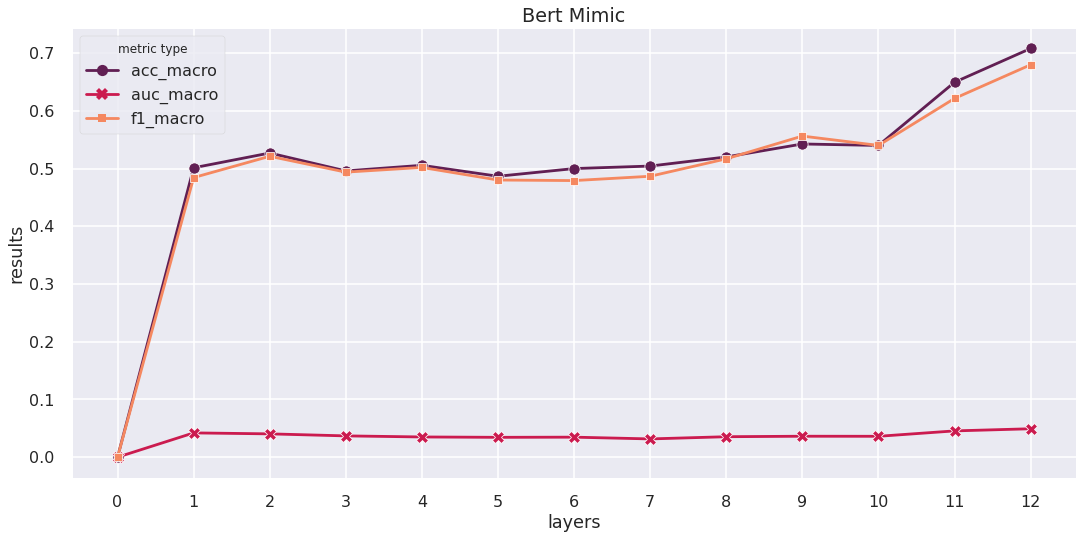

In [ ]:

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 18,8.27
df_bert=plotting(res_bert,"Bert Mimic")

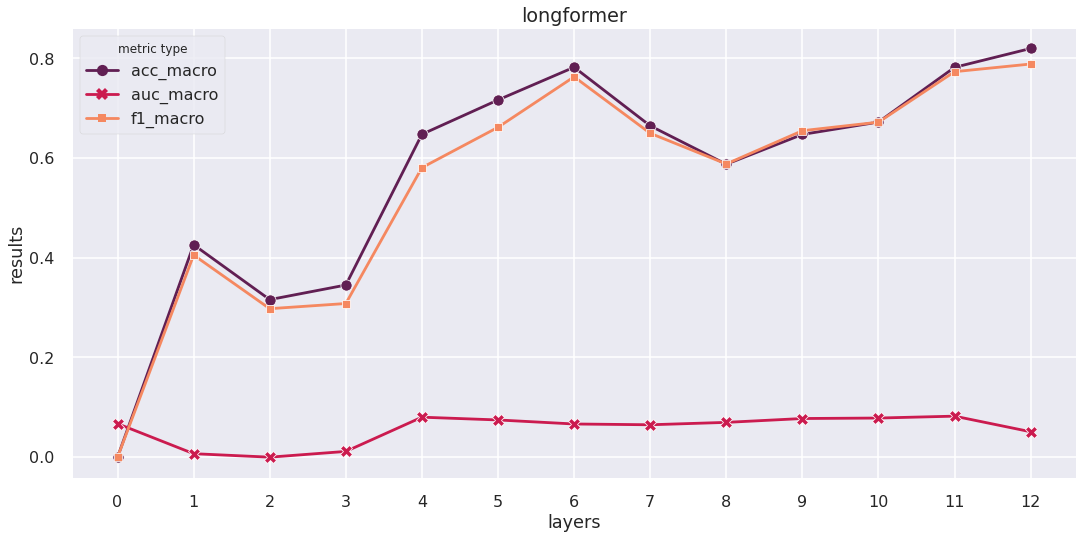

In [ ]:
df_longformer=plotting(res_longformer,"longformer")

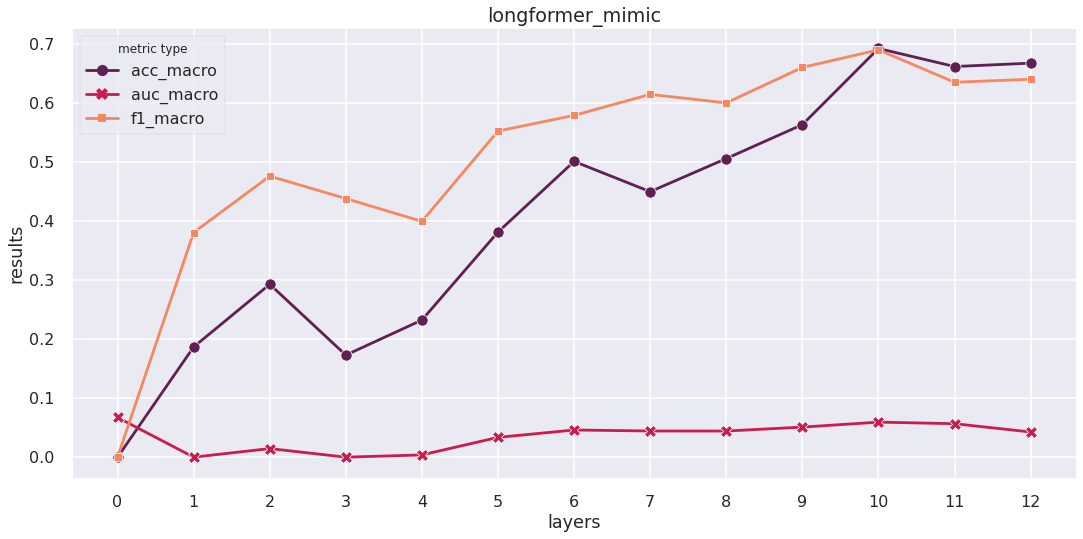

In [ ]:
df_longformer_mimic=plotting(res_longformer_mimic,"longformer_mimic")

## Barplot

In [ ]:
df_bert["f1_macro_diverge"]=df_bert["f1_macro"].diff()
df_longformer["f1_macro_diverge"]=df_longformer["f1_macro"].diff()
df_longformer_mimic["f1_macro_diverge"]=df_longformer_mimic["f1_macro"].diff()
df_bert["f1_micro_diverge"]=df_bert["f1_micro"].diff()
df_longformer["f1_micro_diverge"]=df_longformer["f1_micro"].diff()
df_longformer_mimic["f1_micro_diverge"]=df_longformer_mimic["f1_micro"].diff()

In [ ]:
plot_df=pd.DataFrame()
plot_df["layers"]=["1","2","3","4","5","6","7","8","9","10","11","12"]*3
plot_df["f1_macro"]=pd.concat([df_bert["f1_macro_diverge"][1:],df_longformer["f1_macro_diverge"][1:],df_longformer_mimic["f1_macro_diverge"][1:]],axis=0,ignore_index=True)
plot_df["f1_micro"]=pd.concat([df_bert["f1_micro_diverge"][1:],df_longformer["f1_micro_diverge"][1:],df_longformer_mimic["f1_micro_diverge"][1:]],axis=0,ignore_index=True)
plot_df["model"]=pd.concat([pd.Series(["bert_mimic"]*12),pd.Series(["longformer"]*12),pd.Series(["longformer_mimic"]*12)],axis=0,ignore_index=True)
# f1_df["longformer"]=df_longformer["f1_macro"]
# f1_df["longformer_mimic"]=df_longformer_mimic["f1_macro"]

In [ ]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 23,8.27

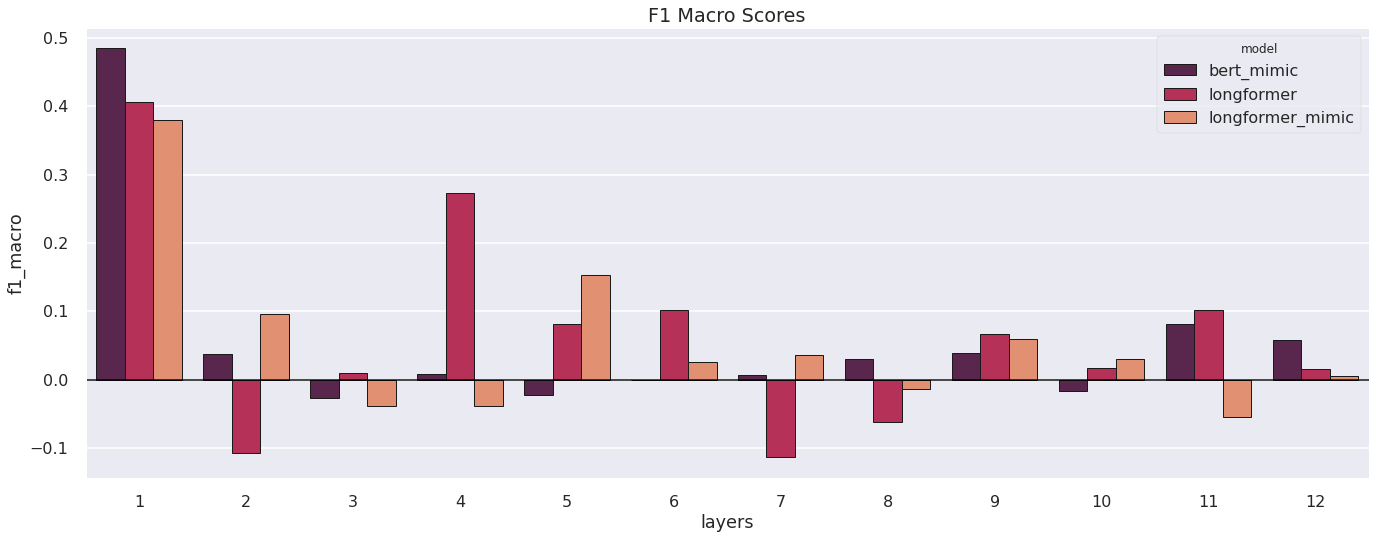

In [ ]:
sns.color_palette("magma", as_cmap=True)

fig=sns.barplot(x="layers",y="f1_macro",data=plot_df, hue="model",palette="rocket",linewidth=1,errcolor=".1", edgecolor=".1",ci=None).set_title("F1 Macro Scores")
fig.axes.axhline(y = 0, color='black', linewidth=2, alpha=.7)

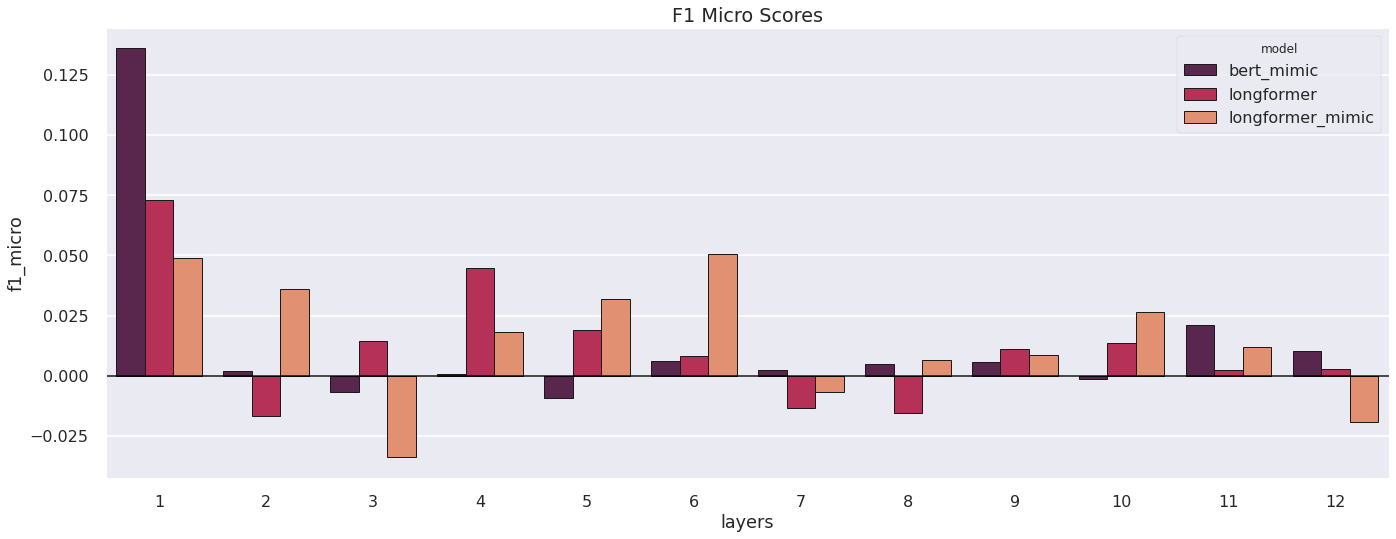

In [ ]:
sns.color_palette("magma", as_cmap=True)

fig=sns.barplot(x="layers",y="f1_micro",data=plot_df, hue="model",palette="rocket",linewidth=1,errcolor=".1", edgecolor=".1",ci=None).set_title("F1 Micro Scores")
fig.axes.axhline(y = 0, color='black', linewidth=2, alpha=.7)